# Preamble

In [1]:
import os, sys, glob
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import scipy.io as sio
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/code/func/')
from proj_environment import set_proj_env
from func import mark_outliers, winsorize_outliers_signed

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale, extra_str = extra_str)

### Setup output directory

In [4]:
print(os.environ['MODELDIR_BASE'])
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400
/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400


## Load data

In [5]:
# Load data
df = pd.read_csv(os.path.join(os.environ['MODELDIR_BASE'], 'df_pheno.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1393, 18)


In [6]:
# Load data
df_node = pd.read_csv(os.path.join(os.environ['MODELDIR_BASE'], 'df_node_base.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)
print(df_node.shape)

(1393, 801)


In [7]:
df_node.head()

,,squeakycleanExclude,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,...,jd_390,jd_391,jd_392,jd_393,jd_394,jd_395,jd_396,jd_397,jd_398,jd_399
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
80961,2632,1,3.531422,4.635224,3.402829,3.454264,3.310552,3.369325,4.240809,3.686324,3.080568,...,0.102312,-0.133829,-0.437651,-0.165046,-0.286214,0.179248,0.129742,0.088795,0.148989,0.040579
80199,2637,0,3.586899,3.304521,2.939940,2.690796,3.159404,3.564934,2.625825,3.358245,2.956705,...,0.133650,-0.010582,-0.045676,-0.049057,-0.127399,0.180499,0.190318,0.134079,0.123161,0.028378
80179,2643,1,2.868061,2.911885,3.216210,2.338475,1.904581,2.746166,2.214152,3.662239,2.718087,...,-0.294902,-0.137902,-0.016284,0.050104,0.126052,0.355791,0.191853,-0.024171,0.443840,0.341406
80812,2646,1,3.061400,3.319993,2.491634,2.460440,2.381677,3.459995,3.197333,3.314158,3.207839,...,-0.065220,-0.222151,-0.144226,0.054314,0.015121,-0.009774,0.140736,0.123537,0.136358,0.087870
80607,2647,1,2.761346,2.756831,3.367205,2.821099,2.594379,3.309250,3.071050,3.740041,2.060887,...,-0.005567,0.079502,-0.017467,-0.105080,-0.200892,0.001936,0.002243,0.028574,-0.193000,-0.208855


# Plots

In [8]:
# Labels
sns.set(style='white', context = 'talk', font_scale = .8)

In [9]:
metrics = ('ct', 'jd')
df_node_mean = pd.DataFrame(index = df_node.index, columns = metrics)
for metric in metrics:
    df_node_mean[metric] = df_node.filter(regex = metric, axis = 1).mean(axis = 1)

/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


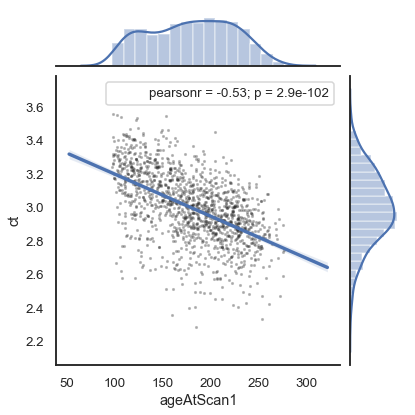

In [10]:
metric_x = 'ageAtScan1'
metric_y = 'ct'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

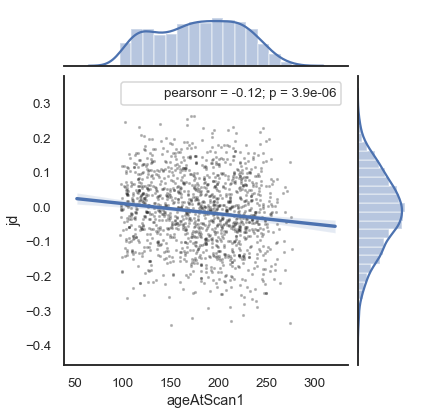

In [11]:
metric_x = 'ageAtScan1'
metric_y = 'jd'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [12]:
my_str = os.environ['MODELDIR'].split('/')[-1]
my_str = my_str.split('_')[-1]
my_str

'400'

In [13]:
df_node.shape

(1393, 801)

## Nuisance regression

### cortical thickness

In [14]:
# labels of nuisance regressors
nuis = ['averageManualRating']
print(nuis)
df_nuis = df[nuis]
df_nuis = sm.add_constant(df_nuis)

my_str = '|'.join(metrics); print(my_str)
cols = df_node.filter(regex = my_str, axis = 1).columns

mdl = sm.OLS(df_node.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_node.loc[:,cols] = df_node.loc[:,cols] - y_pred

['averageManualRating']
ct|jd


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [15]:
df_node.head()

,,squeakycleanExclude,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,...,jd_390,jd_391,jd_392,jd_393,jd_394,jd_395,jd_396,jd_397,jd_398,jd_399
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
80961,2632,1,0.046866,1.374201,0.284174,0.692039,0.756136,-0.114470,1.388989,-0.131978,0.362790,...,0.092898,-0.100384,-0.377800,-0.141792,-0.205425,0.165998,0.174236,0.053945,0.191099,0.049108
80199,2637,0,0.102344,0.043499,-0.178715,-0.071429,0.604988,0.081139,-0.225996,-0.460057,0.238927,...,0.124235,0.022863,0.014175,-0.025802,-0.046611,0.167249,0.234812,0.099230,0.165270,0.036907
80179,2643,1,-0.610605,-0.353387,0.178101,-0.384462,-0.479214,-0.660467,-0.574807,-0.187702,0.041654,...,-0.304443,-0.110247,0.048364,0.061442,0.204653,0.333472,0.242536,-0.068638,0.474620,0.347959
80812,2646,1,-0.423155,0.058970,-0.627021,-0.301784,-0.172739,-0.023800,0.345512,-0.504145,0.490061,...,-0.074634,-0.188706,-0.084375,0.077569,0.095909,-0.023024,0.185231,0.088687,0.178468,0.096399
80607,2647,1,-0.723209,-0.504191,0.248550,0.058874,0.039963,-0.174545,0.219230,-0.078261,-0.656891,...,-0.014981,0.112947,0.042383,-0.081825,-0.120103,-0.011314,0.046737,-0.006276,-0.150890,-0.200326


In [16]:
df_node_mean = pd.DataFrame(index = df_node.index, columns = metrics)
for metric in metrics:
    df_node_mean[metric] = df_node.filter(regex = metric, axis = 1).mean(axis = 1)

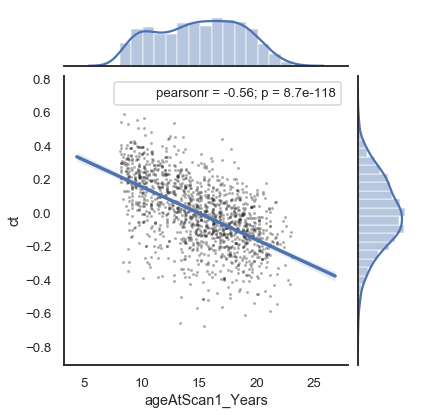

In [17]:
metric_x = 'ageAtScan1_Years'
metric_y = 'ct'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

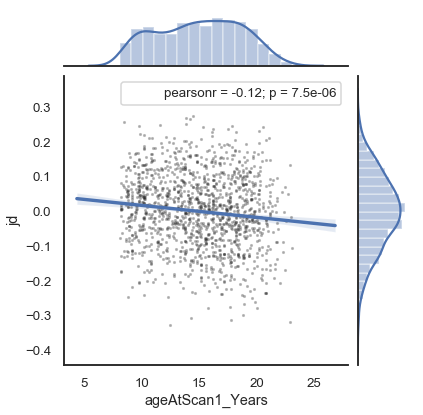

In [18]:
metric_x = 'ageAtScan1_Years'
metric_y = 'jd'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

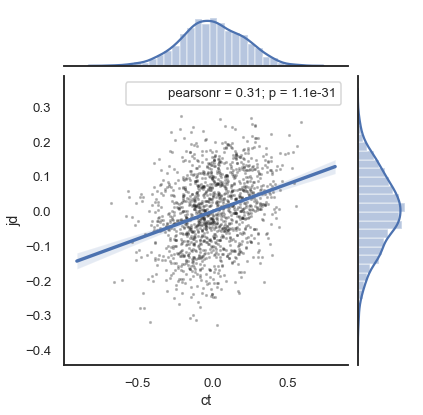

In [19]:
metric_x = 'ct'
metric_y = 'jd'
f = sns.jointplot(x = df_node_mean[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [20]:
R = np.zeros(num_parcels-1)
for i in range(0,num_parcels-1):
    R[i] = sp.stats.pearsonr(df_node.loc[:,'ct_'+str(i)],df_node.loc[:,'jd_'+str(i)])[0]

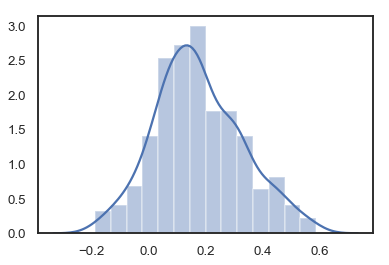

In [21]:
sns.distplot(R)

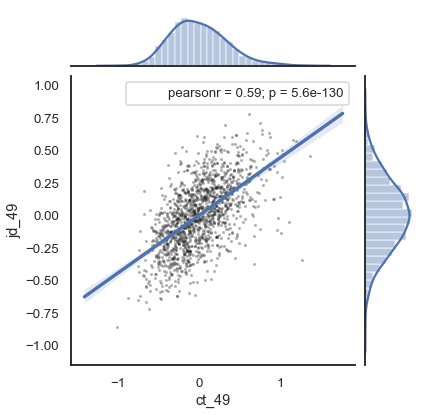

In [22]:
f = sns.jointplot(x = df_node['ct_'+str(np.argmax(R))], y = df_node['jd_'+str(np.argmax(R))], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

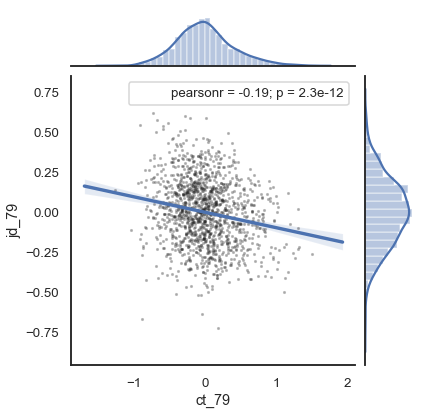

In [23]:
f = sns.jointplot(x = df_node['ct_'+str(np.argmin(R))], y = df_node['jd_'+str(np.argmin(R))], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [24]:
val = np.min(np.abs(R))

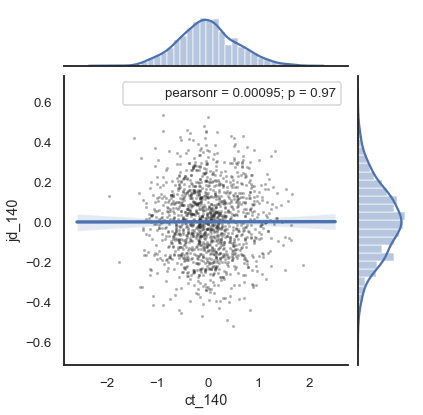

In [25]:
f = sns.jointplot(x = df_node['ct_'+str(np.where(R == val)[0][0])], y = df_node['jd_'+str(np.where(R == val)[0][0])], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [26]:
df_node.isna().any().any()

False

## Save out

In [27]:
# Save out
df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_clean.csv'))